# From Tone to Tell: A Pipeline Practice for Deceptive Story Classification
### Author
**Student Name**:  Zihua Rong  
**Student ID**:  221165980  

# I. Problem formulation

Generally speaking, the audio classification task can be defined as: 

Given an audio signal $x(t)$, which contains multiple sampling values across time dimension, the goal is to classify it into a predefined set of categories $C = {c_1, c_2,..., c_n}$, where each category $c_i$ represents a specific sound type, such as speech, music, environmental sounds, etc. This task can be formalized as the following mathematical expression: $$\hat{c} = f(x(t), \theta)$$

Where:
- $\hat{c}$ is the predicted category of the audio signal by the model
- $f$ is the audio classification model, a function containing multiple parameters $\theta$ that converts the audio signal $x(t)$ into a probability distribution over the categories or directly predicts the category label
- $x(t)$ is the input audio signal 

The task objective is to minimize the error between the predicted category labels by the model and the true category labels, for example, by optimizing with the cross-entropy loss function. $$L(\theta)=-\frac1N\sum_{n=1}^N\sum_{i=1}^ny_{ni}\log(p_{ni})$$
Herein:
- $N$ represents the number of training samples.
- $y_{ni}$ is the true class label of the $n$ th sample, taking values of 0 or 1, where $y_{ni}=1$ indicates that the sample belongs to class $c_i$, and $y_{ni}=0$ indicates that it does not belong to this class.
- $p_{ni}$ is the probability predicted by the model that the $n$th sample belongs to class $c_i$.

# II. Investigation

$\quad$ During the preparation phase, I extensively researched existing methods for handling audio classification tasks.  
$\quad$ The difficulty of audio classification is that the audio signal contains a large number of data points, and the model needs to compress the input dimension effectively and extract the key features. Existing models use different modeling assumptions and feature extraction methods to process audio data.
#### Classic ML & DL models:

- **SVM** (Support Vector Machine):  
SVM is a supervised learning method based on maximum interval classification. Its core idea is to find a hyperplane to separate different categories of data points and maximize the distance between the hyperplane and data points. In an audio classification task, the SVM typically converts the audio signal into a Maier frequency cepstrum coefficient (MFCC) or other feature vectors, which are then input into the SVM model for classification.
- **RandomForest**:  
RandomForest is an ensemble learning method based on decision trees that builds multiple decision trees and votes them to obtain a final result. Each decision tree is trained from the original data set using random resampling and feature subset methods. RandomForest has the advantages of strong robustness and good generalization ability, and is suitable for processing unbalanced data sets. The feature extraction method is similar to SVM. Finally, the trained RandomForest model is used to classify the new audio signal, and the category of the new audio signal is predicted according to the results of most decision trees.
- **CNN** (Convolutional Neural Network):  
CNN is a deep learning model whose core idea is to extract local features through convolutional layers and reduce feature dimensions through pooling layers. When CNN is applied to the task of audio classification, the amplitude diagram or spectrum diagram of audio is regarded as a two-dimensional image, and the audio information is learned according to the method of processing images. CNNS have been shown to be effective at capturing local features of audio signals, such as phonemic features in speech signals.
- **Transformer**:  
Transformer is a deep learning model based on a self-attention mechanism that models audio signals by capturing long-distance dependencies in audio sequences. In audio classification tasks, Transformer can directly process the timing data of the audio signal and learn more complex feature representations.  

$\quad$ Since audio datasets tend to be small and categorically unbalanced, data enhancement is an important means to improve the generalization ability of models. Common data enhancement methods include:

- **Time transformation** : such as time stretching, time migration, speed modulation, etc., can increase the length and diversity of audio sequences.
- **Frequency conversion** : such as pitch shift, noise, etc., can increase the complexity and robustness of the audio signal.
- **Data mixing** : Mixing together different categories of audio signals, for example, can increase the generalization ability of the model.  

$\quad$ Finally, I adopted the `audiomentations` module to implement various data enhancements to build the audio dataset, and adopted the Transformer architecture's neural network model `openai/whisper-tiny` as the backbone model to handle this deceptive story classification task.

# III. Methodology

$\quad$ The pipeline's a priori assumption is that the audio in the data set itself contains *enough information* to determine whether the story told by the audio is real or deceptive. Therefore, under this assumption, the model does not add additional audio transcripts as input, but only gives judgments based on audio data. In general, the pipeline uses a model based on the Transformer architecture to handle audio classification tasks, including data enhancement, data preprocessing, model training and evaluation. The original data set was expanded to **four times** after transformation, totaling **8GB** for about **10** hours, of which 80% was used as a training set and 20% as a test set, *avoiding potential data leakage risks*. The process uses a pre-trained Whisper model to extract audio **log-mel spectrogram** features and **fine-tune** the `whisper-tiny` model to classify them through a custom SpeechClassifier. **Cross entropy** is defined as a loss function in training, and **AdamW** optimizer is used to improve the parameters, and finally the model performance is evaluated with **Accuracy** and **F1 score**.


# IV. Implemented ML prediction pipelines

The assembly line can be divided into the following parts
- Data enhancement and preprocessing:  
In the [data augment.py](./data_augment.ipynb) program, three transformation methods are implemented using `audiomentations` library. 1. Add Gaussian white noise, 2. Pitch offset, 3. Time domain mask. The program quadrupled the size of the original data, totaling 8 GB of data for nearly 10 hours. At the same time, the program also adds the transformed audio information to the [json](./dataset/info/) file ( ./dataset/info/ ) and completes the corresponding label for each voice.  
Then in the [main](./CBU5201_miniproject.ipynb) program, the data set is read and split first (carefully without the risk of data leakage), the audio data is downsampled to 16KHz, the data set is reorganized to match model's expected format, the mel spectrum features are extracted, and the processed data set is saved to disk.
- Model training:  
Create training, validation, and test data loaders with `DataLoader`.  
Defining a `SpeechClassifier` class defines the model structure and forward propagation.  
Training is done using the **Cross Entropy Loss** function and using the **AdamW** optimizer.  
During training, the **Accuracy** and **F1 score** of the verification set are calculated at the end of each epoch.
- Model evaluation:  
Evaluate on a test set using the finetuned model.  
Calculation **Accuracy** and **F1 score**.

More details are listed below.

## (a) Transformation stage

$\quad$ In this part, the pipeline includes data enhancement with three transformations, reading and splitting the data set, audio downsampling, reorganizing the data set, extracting Meir spectrum features, and saving the processed data set to disk.  

$\quad$ Given that the original dataset has only 100 audio tracks, totaling about 2.5 hours, it's not enough to fine-tune a whisper tiny model with 39 million parameters. Therefore, data enhancement introduced this pipeline as a widely used method in deep learning.  
Data enhancement is to make various transformations on the original data set and the possible changes of the data in reality, so as to expand the scale of the data set, improve the generalization ability of the model during training, and avoid the model can only work on the refined data set. For example, when training a cv model, picture data is rotated and scaled to simulate real pictures that might be encountered in reality.  
$\quad$ In the [data augment.py](./data_augment.ipynb) program, three transformations are implemented using audiomentations library. Add Gaussian white noise, 2. Pitch offset, 3. Time domain mask. Because I don't think the model can tell whether a story is real or made up by detecting the clarity of the speech, the pitch of the voice, or just a small sound.  

$\quad$ At the same time, the program also adds the transformed audio information to the json file and completes the corresponding label for each speech.  

$\quad$ In the end, through data enhancement, the original data was enlarged by four times, to a total of 8.4G, lasting nearly 10 hours.  

In [9]:
import pandas as pd
import json

csv_file_path = "./Deception/CBU0521DD_stories_attributes.csv"  # header: filename|Language|Story_type


df = pd.read_csv(csv_file_path)
df.insert(0, 'id', range(len(df)))
df.insert(2,"augment", "none") # FIXME: unify case
# df.filename = "./Deception/CBU0521DD_stories/"+df.filename


json_data = df.to_json(orient='records', indent=4)

json_file_path = "./dataset/info/normal_audio.json"


with open(json_file_path, 'w', encoding='utf-8') as file:
    file.write(json_data)

print(f"JSON data has been saved to {json_file_path}")


JSON data has been saved to ./dataset/info/normal_audio.json


In [10]:
df

id   filename augment Language       Story_type
0    0  00001.wav    none  Chinese       True Story
1    1  00002.wav    none  Chinese       True Story
2    2  00003.wav    none  Chinese       True Story
3    3  00004.wav    none  Chinese       True Story
4    4  00005.wav    none  Chinese       True Story
..  ..        ...     ...      ...              ...
95  95  00096.wav    none  English       True Story
96  96  00097.wav    none  Chinese  Deceptive Story
97  97  00098.wav    none  Chinese       True Story
98  98  00099.wav    none  Chinese  Deceptive Story
99  99  00100.wav    none  Chinese       True Story

[100 rows x 5 columns]

$\quad$ After that, I summarized and reordered all the audio information in the json file, using the following code to split the original set into the training data set, which accounts for 80%, and the test data set, which accounts for 20%.  

$\quad$ To **avoid the risk of a data leakage**, I didn't put two pieces of audio that actually tell the same story on either side, even though they were enhanced differently. So, I first took 20 pieces from the original 100 pieces of audio set and put them into the test set, half of which were real and half of which were made up, and then added all the enhanced audio based on these 20 pieces into the test set. This ensures that all the audio in the test set is something the model has never seen before, and that their **label distribution is balanced**.  

In [11]:
import json
import random
import os

# input
json_dir_path = "./dataset/info/"
json_files = [
    'normal_audio.json',
    'noisy_audio_info.json',
    'pitchshift_audio_info.json',
    'timemask_audio_info.json'
]
# output
train_audio = "./dataset/info/train_audio.json"
eval_audio = "./dataset/info/eval_audio.json"

# initial list to store all json
all_audio_info = []

# load in all files
for json_file in json_files:
    with open(os.path.join(json_dir_path,json_file), 'r') as jfile:
        audio_info_list = json.load(jfile)
        all_audio_info.extend(audio_info_list)

# only classify normal_audio.json by Story_type to avoid redundancy
true_stories = [audio for audio in all_audio_info[0:100] if audio['Story_type'] == "True Story"]
deceptive_stories = [audio for audio in all_audio_info[0:100] if audio['Story_type'] == "Deceptive Story"]

# randomly sample 10 True Story and 10 Deceptive Story, and store them id
eval_true_ids = random.sample([audio['id'] for audio in true_stories], 10)
eval_deceptive_ids = random.sample([audio['id'] for audio in deceptive_stories], 10)

# initial list to store eval_list and train_list
eval_audio_list = []
train_audio_list = []

# sample audios with same id from other json
for audio in all_audio_info:
    if audio['id'] in (eval_deceptive_ids+eval_true_ids):
        eval_audio_list.append(audio)
    else:
        train_audio_list.append(audio)


# write to eval_audio.json
with open(eval_audio, 'w') as eval_file:
    json.dump(eval_audio_list, eval_file, indent=4)

# write to train_audio.json
with open(train_audio, 'w') as train_file:
    json.dump(train_audio_list, train_file, indent=4)


In [12]:
print("eval audio ids are", (eval_true_ids + eval_deceptive_ids))
print("eval audio num is", len(eval_audio_list), "with half true stories and half deceptive ones")
print("train audio num is", len(train_audio_list), "with half true stories and half deceptive ones")

eval audio ids are [40, 24, 60, 81, 7, 72, 38, 66, 77, 48, 32, 8, 89, 41, 11, 45, 37, 29, 96, 98]
eval audio num is 80 with half true stories and half deceptive ones
train audio num is 320 with half true stories and half deceptive ones


In [13]:
from datasets import load_dataset
import tqdm as notebook_tqdm

train_audio = "./dataset/info/train_audio.json"
eval_audio = "./dataset/info/eval_audio.json"

StoryDataset = load_dataset("json",data_files={"train":train_audio, "eval":eval_audio})
# StoryDataset = load_dataset("json",data_files={"train":train_audio, "eval":eval_audio},streaming=True)

StoryDataset_train = StoryDataset['train']
StoryDataset_train = StoryDataset_train.rename_column("Story_type","label")
StoryDataset_eval = StoryDataset['eval']
StoryDataset_eval = StoryDataset_eval.rename_column("Story_type","label")



Generating train split: 320 examples [00:00, 3661.58 examples/s]
Generating eval split: 80 examples [00:00, 6558.47 examples/s]


$\quad$ In order to ensure that the subsequent training function can read the data field correctly, I renamed the story type field with the `convert_label` function, and converted the original value into an integer to facilitate calculation of the loss function. Now label 1 corresponds to True story, and 0 corresponds to Deceptive story.  

In [14]:
import librosa
import os

dataset_dir = "./dataset/audio/"

def convert_label(example):
    label = int(0)
    label = 1 if example['label'] == 'True Story' else 0
    example['label'] = label
    return example

Label_list = ["Deceptive Story", "True Story"]

id2label = {
    str(i): Label_list[i]
    for i in range(len(Label_list))
}

label2id = {v: k for k, v in id2label.items()}

print(f"id '1' stand for label '{id2label['1']}'")

# add audio data and sampling rate into dataset
def load_array_and_fs(example):

    filename = example['filename']
    example['filename'] = os.path.join(dataset_dir, filename)
    new_filename = example['filename']

    audio_array, sample_rate = librosa.load(new_filename,mono=True)
    audio = {'array':audio_array, 'sample_rate':sample_rate}
    example['audio'] = audio
    return example

# If load dataset by streaming
# convert iterable dataset to flatten type
# StoryDataset = StoryDataset.flatten()
# StoryDataset.save_to_disk('./dataset/StoryDataset/')

id '1' stand for label 'True Story'


In [15]:
StoryDataset_train = StoryDataset_train.map(load_array_and_fs)
StoryDataset_train = StoryDataset_train.map(convert_label)

Map: 100%|██████████| 320/320 [00:29<00:00, 10.77 examples/s]


$\quad$ In addition, because the whisper model only accepts audio clips with a sample rate of 16kHz, our audio data needs to be downsampled. The `downsample_audio` function uses `librosa` `resample` function.  
$\quad$ The Whisper model is an input value based on a logarithmic Mayer spectrum graph of audio, unlike models such as `Hubert`, which take the original audio sequence as input. Therefore, this part of the code `shortcut_and_log_mel` is to extract the log-Mel spectrum of the audio as the characteristic value. Here, the whisper feature extraction function is used for calculation. It adopts a sliding window to read an audio clip of 16khz sampling rate for 30 seconds each time. The adjacent Windows overlap 160 points, so the length of each audio clip is 16KHz * 30sec / 160 overlap = 3000 points. A total of 80 Mel filters are calculated on the spectrum, that is, the frequency range is divided into 80 segments. Finally, a feature vector of size (1,80,3000) is obtained, which significantly reduces the data dimension compared to the original audio data.  

In [16]:
from datasets import Audio
from transformers import WhisperFeatureExtractor
import numpy as np


# StoryDataset_train = StoryDataset_train.cast_column("audio", Audio(sampling_rate=16_000))

# downsample to 16KHZ
def downsample_audio(sample, target_sample_rate):
    original_sample_rate = sample['audio']['sample_rate']
    audio_array = sample['audio']['array']
    if type(audio_array) is list:
        audio_array = np.array(audio_array)
        audio_array = audio_array.astype(np.float32)
    
    if original_sample_rate != target_sample_rate:
        # downsample to 16KHz
        downsampled_array = librosa.resample(y=audio_array, orig_sr=original_sample_rate, target_sr=target_sample_rate)
        
        sample['audio']['array'] = downsampled_array
        sample['audio']['sample_rate'] = target_sample_rate
    return sample


Model = "./whisper-tiny"

feature_extractor = WhisperFeatureExtractor.from_pretrained("./whisper-tiny")


def shortcut_and_log_mel(example):
    audio = example["audio"]
    features = feature_extractor(example["audio"]["array"], return_tensors="np", sampling_rate=example["audio"]["sample_rate"]) 
    # input_features is the log-mel spectrogram of the provided audio
    # split fequency domain into 80 segment, distributed according to the auditory characteristics of the human
    # and calculate with mel filter
    # overlaping windows (defaults to 160) of STFT is used to obtain the Mel Frequency coefficients
    # 16KHz * 30sec / 160 overlap = 3000 points
    # return in type np.ndarray, shape is (1,80,3000)
    # array is normalized to have zero mean and unit variance
    example["input_features"] = features.input_features
    return example


In [17]:
# implement downsample
target_sample_rate = 16000
StoryDataset_train = StoryDataset_train.map(lambda x: downsample_audio(x, target_sample_rate))
# extract log-mel specturm features
StoryDataset_train = StoryDataset_train.map(shortcut_and_log_mel)


Map: 100%|██████████| 320/320 [07:47<00:00,  1.46s/ examples]


Then the same transformation is implemented on test set

In [18]:
StoryDataset_eval = StoryDataset_eval.map(load_array_and_fs)
StoryDataset_eval = StoryDataset_eval.map(convert_label)
target_sample_rate = 16000
StoryDataset_eval = StoryDataset_eval.map(lambda x: downsample_audio(x, target_sample_rate))
StoryDataset_eval = StoryDataset_eval.map(shortcut_and_log_mel)

Map: 100%|██████████| 80/80 [02:03<00:00,  1.54s/ examples]


Store edited dataset onto disk

In [19]:
# Store datasets
StoryDataset_train.save_to_disk('./dataset/StoryDataset_train/')
StoryDataset_eval.save_to_disk('./dataset/StoryDataset_eval/')

Saving the dataset (2/2 shards): 100%|██████████| 80/80 [00:06<00:00, 12.75 examples/s]


In [20]:
from datasets import load_from_disk
from IPython.display import Audio, display
import numpy as np

StoryDataset_train = load_from_disk('./dataset/StoryDataset_train/')
StoryDataset_eval = load_from_disk('./dataset/StoryDataset_eval/')

Label_list = ["Deceptive Story", "True Story"]

id2label = {
    str(i): Label_list[i]
    for i in range(len(Label_list))
}

label2id = {v: k for k, v in id2label.items()}

num_labels = len(Label_list)


print(f"Try to listen the edited audio {StoryDataset_train[101]['filename']} with label {id2label[str(StoryDataset_train[101]['label'])]}")
display(Audio(data=np.asarray(StoryDataset_train[101]["audio"]["array"]), autoplay=True, rate=16000))



Try to listen the edited audio ./dataset/audio/noisy_00026.wav with label Deceptive Story


The feature mel spectrogram is in shape (1,80,3000)

In [21]:
from transformers import WhisperModel, WhisperFeatureExtractor

model_checkpoint = "./whisper-tiny"

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_checkpoint)

features = feature_extractor(StoryDataset_train[0]["audio"]["array"], return_tensors="np", sampling_rate=StoryDataset_train[0]["audio"]["sample_rate"])
print(type(features.input_features))
features.input_features.shape == (1,80,3000)

<class 'numpy.ndarray'>


True

look like that

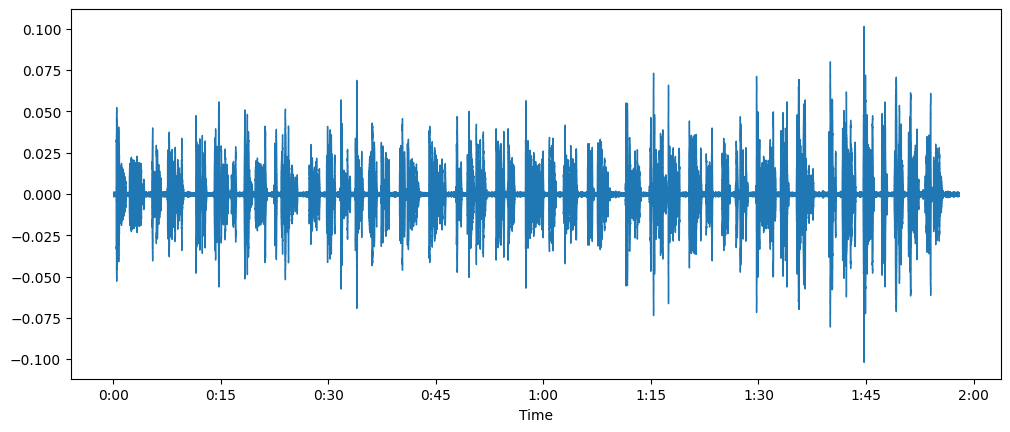

In [22]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

dataset_dir = "./dataset/audio/"


# read from streaming datasets.dataset_dict.IterableDatasetDict
# array = list(StoryDataset_train.take(1))[0]['array']
# sampling_rate = list(StoryDataset_train.take(1))[0]['sample_rate']

array = np.asarray(StoryDataset_train[0]['audio']['array'])
sampling_rate = StoryDataset_train[0]['audio']['sample_rate']

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)


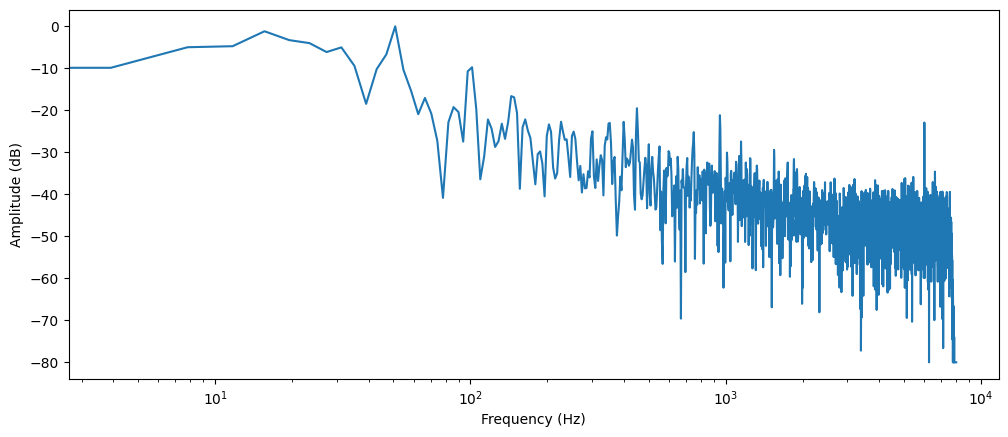

In [23]:
import numpy as np

dft_input = array[:4096]

# calculate DFT
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# convert amplitude to dB scale
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# match with frequency
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

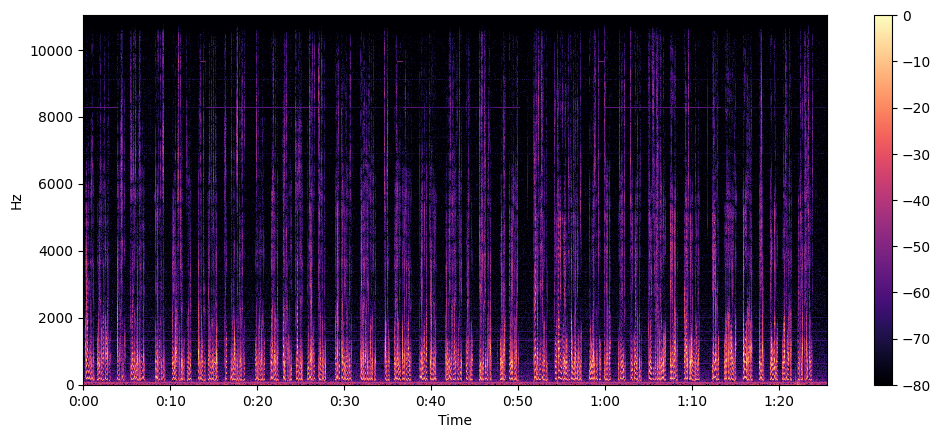

In [24]:
import numpy as np

D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

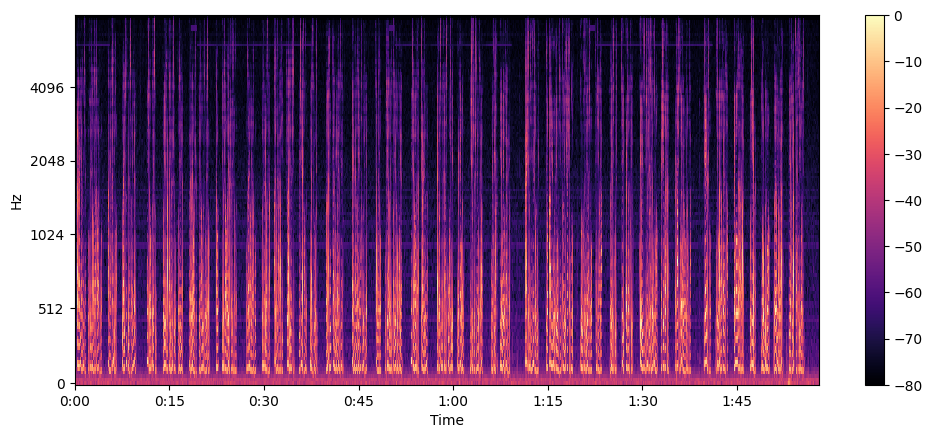

In [25]:
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()

In [26]:
print(S_db.shape) # 1025*3685=3,777,125
print(array.shape) # 1886670 for single channel


(1025, 3685)
(1886670,)


## (b) Model stage

$\quad$ In the pipeline, I used whisper as the base model. The whisper model was released by openai in 2022 and is primarily used for multilingual text transcription, speech translation, language recognition tasks, and audio generation tasks, but has proven to be versatile for many more tasks.  
$\quad$ The advantage of whisper is that it supports multiple languages when pre-trained, which makes it more effective when working with our data sets. The model uses the Transformer architecture, which helps it capture contextual information over long distances and better understand complex patterns in audio signals.  
$\quad$ For the audio classification task, Hubert, wave2vec and other models are equally effective, but because `whisper-tiny` has the smallest parameter count (39M), it is easier to fine-tune and test, so I chose whisper for this pipeline.  
$\quad$ In the pretraining-fine-tuning paradigm, the output layer of the pretrained model is usually modified to accommodate different downstream tasks. In my model, I added **four** **learnable linear layers** to whisper's logist output to fit the audio classification task, so the fine-tuning process was optimizing the parameters of the linear layer. I had tested more or less layers before, but the experiment proved that four layers was the best parameter.  

In [27]:
import os
import numpy as np
import datasets
from datasets import load_from_disk, Dataset
import logging
import torch
import torch.nn as nn
import torch.utils.data
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
from transformers import WhisperModel, WhisperFeatureExtractor

# Load the pre-trained Whisper model and feature extractor
model_checkpoint = "./whisper-tiny"

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_checkpoint)
encoder = WhisperModel.from_pretrained(model_checkpoint)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SpeechClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, audio_data,  text_processor):
        self.audio_data = audio_data
        self.text_processor = text_processor

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, index):
        # Check if input features are present in the data
        if "input_features" in self.audio_data[index]:
            if isinstance(self.audio_data[index]["input_features"], np.ndarray) and self.audio_data[index]["input_features"].ndim == 3:
                input_features = torch.tensor(self.audio_data[index]["input_features"]) # convert from nump.narray to torch.tensor
            else:
                inputs = self.text_processor(self.audio_data[index]["audio"]["array"],
                                             return_tensors="pt",
                                             sampling_rate=self.audio_data[index]["audio"]["sample_rate"])
                input_features = inputs.input_features
        else:
            raise KeyError(f"Not exist input_features key in {self.audio_data}")
        
        # Create decoder input IDs and convert labels to a tensor
        decoder_input_ids = torch.tensor([[1, 1]]) * encoder.config.decoder_start_token_id
        labels = np.array(self.audio_data[index]['label'])

        return input_features, decoder_input_ids, torch.tensor(labels)
    
# Define label lists and mappings
Label_list = ["Deceptive Story", "True Story"]

id2label = {
    str(i): Label_list[i]
    for i in range(len(Label_list))
}

label2id = {v: k for k, v in id2label.items()}

num_labels = len(Label_list)

# Load datasets from disk
StoryDataset_train = load_from_disk('./dataset/StoryDataset_train/')
StoryDataset_eval = load_from_disk('./dataset/StoryDataset_eval/')


# 10% of the training set for valadation
train_size = int(len(StoryDataset_train) * 0.1)

# Split the dataset randomly into training and validation sets
temp_dataset = StoryDataset_train.train_test_split(test_size=0.1, seed=42)
StoryDataset_train = temp_dataset['train']
StoryDataset_val = temp_dataset['test']

train_dataset = SpeechClassificationDataset(StoryDataset_train,  feature_extractor)
test_dataset = SpeechClassificationDataset(StoryDataset_eval,  feature_extractor)
val_dataset = SpeechClassificationDataset(StoryDataset_val,  feature_extractor)

# Set batch size
batch_size = 16

# Create DataLoader instances for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the custom dataset class for speech classification
class SpeechClassifier(nn.Module):
    def __init__(self, num_labels, encoder):
        super(SpeechClassifier, self).__init__()
        self.encoder = encoder
        # Define a Linear Layer on top of the encoder for classification
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 192),# 384
            nn.ReLU(),
            nn.Linear(192, 96),
            nn.ReLU(),
            nn.Linear(96, 48),
            nn.ReLU(),
            nn.Linear(48, num_labels)
        )

    def forward(self, input_features, decoder_input_ids):
        outputs = self.encoder(input_features, decoder_input_ids=decoder_input_ids)
        # Extract the pooled output from the last hidden state
        pooled_output = outputs['last_hidden_state'][:, 0, :]
        # Pass the pooled output through the classifier to get logits
        logits = self.classifier(pooled_output)
        return logits
    

model = SpeechClassifier(num_labels, encoder).to(device)
# Define the optimizer with specific hyperparameters
optimizer = AdamW(model.parameters(), lr=2e-5, betas=(0.9, 0.999), eps=1e-08)
# Define the loss function for classification
criterion = nn.CrossEntropyLoss()

# init logging
logger_train = logging.getLogger('logger_train')

logger_train.setLevel(logging.INFO)

train_handler = logging.FileHandler('./output/train_log.txt')

formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

train_handler.setFormatter(formatter)

logger_train.addHandler(train_handler)

# Define the training function
def train(model, train_loader, val_loader, optimizer,  criterion, device, num_epochs):

    best_accuracy = 0.0 # Initialize the best validation accuracy

    for epoch in range(num_epochs):

        model.train()

        for i, batch in enumerate(train_loader):

            input_features, decoder_input_ids, labels = batch # Unpack the batch

            input_features = input_features.squeeze() # Remove single-dimensional entries
            input_features = input_features.to(device)

            decoder_input_ids = decoder_input_ids.squeeze() # Remove single-dimensional entries
            decoder_input_ids = decoder_input_ids.to(device)

            labels = labels.view(-1) # Flatten the labels
            labels = labels.to(device)

            optimizer.zero_grad() # Zero the parameter gradients

            logits = model(input_features, decoder_input_ids)

            loss = criterion(logits, labels)
            loss.backward() # Backward pass to compute gradients

            optimizer.step() # Update weights based on computed gradients

            if (i+1) % 8 == 0:
                logger_train.info(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item() :.4f}')
                train_loss = 0.0

        val_loss, val_accuracy, val_f1, _ , _ = evaluate(model, val_loader, device)

        # Save the model if the validation accuracy has improved
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), './output/whisper_tiny_finetuned.pt')

        logger_train.info("========================================================================================")
        logger_train.info(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}, Best Accuracy: {best_accuracy:.4f}')
        logger_train.info("========================================================================================")


def evaluate(model, data_loader,  device):

    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad(): # Disable gradient computation for evaluation

        for i, batch in enumerate(data_loader):

          input_features, decoder_input_ids, labels = batch

          input_features = input_features.squeeze()
          input_features = input_features.to(device)

          decoder_input_ids = decoder_input_ids.squeeze()
          decoder_input_ids = decoder_input_ids.to(device)

          labels = labels.view(-1)
          labels = labels.to(device)

          optimizer.zero_grad() # Zero the parameter gradients

          logits = model(input_features, decoder_input_ids)

          loss = criterion(logits, labels) # Compute the loss
          total_loss += loss.item()

          _, preds = torch.max(logits, 1)
          all_labels.append(labels.cpu().numpy())
          all_preds.append(preds.cpu().numpy())

    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return loss, accuracy, f1, all_labels, all_preds


# V. Dataset

Based on the original data set, I implemented three data enhancement methods using music library to expand the data set. 1. Add Gaussian white noise, 2. Pitch offset, 3. Time domain mask. Because I don't think the model can tell whether a story is real or made up by detecting the clarity of the speech, the pitch of the voice, or just a small sound. In the end, through data enhancement, the original data was enlarged by four times, to a total of 8GB, lasting nearly 10 hours.  

Transcripts of each audio were not added to the dataset because I assumed that there was already *enough information in the audio to determine whether the story was true or fabricated*.  

When splitting the training set and the test set, I try to ensure that there is **no risk of data leakage**. There is no such thing as Variants of the same audio in the test set have been seen by the model during training. The ratio between the training set and the test set was 80% vs 20%, and each was made up of half true stories and half deceptive stories to ensure that the model did not have a particular preference when judging.  

During the training, I also extracted 10% from the original training set as the **validation set** to evaluate the actual capability improvement of the model during the training process, so as to prevent overfitting.  

In [28]:
print(StoryDataset_train)
print(StoryDataset_val)
print(StoryDataset_eval)

Dataset({
    features: ['id', 'filename', 'augment', 'Language', 'label', 'audio', 'input_features'],
    num_rows: 288
})
Dataset({
    features: ['id', 'filename', 'augment', 'Language', 'label', 'audio', 'input_features'],
    num_rows: 32
})
Dataset({
    features: ['id', 'filename', 'augment', 'Language', 'label', 'audio', 'input_features'],
    num_rows: 80
})


# VI. Experiments and results

The fine-tuning process is actually training the newly added linear layer, optimizing its parameters to better represent the learned audio features of the base model. After many tests, the number and dimension of linear layers, learning rate, number of epoch, batch size and other important parameters will affect the fine-tuning effect.  

After several rounds of tests, I set the number of linear layers as 4, the learning rate as 2e-5, the training epoch as 4, and the batch size as 16, which is the best combination of training parameters. Because the experiment found that when the number of linear layers is larger or the batch size is smaller, the training loss will float up and down and not converge. When the epoch of training rounds is larger, training losses do not decrease significantly, but may increase the risk of overfitting.  

After 2 hours of fine tuning on A40 (48GB) GPU using the best training parameter combination, the accuracy of the model on the deceptive story is **0.85**, f1 score is **0.77**, the **avg accuracy** is **0.80**, and the **avg f1 score** is **0.79**. It can be concluded that the model achieves baseline performance and can distinguish story categories well.

<mark>Check the [train_log](./output/train_log.txt) file for full results, as the output in the jupternotebook may have been truncated or modified</mark>

In [ ]:
num_epochs = 4
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
2024-12-29 02:30:25,100 - INFO - Epoch 1/4, Batch 8/18, Train Loss: 0.6752
2024-12-29 02:41:38,559 - INFO - Epoch 1/4, Batch 16/18, Train Loss: 0.6081


In [20]:
import datasets
from datasets import Dataset, load_from_disk
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import DataLoader
import logging

# init logging
logger_eval = logging.getLogger('logger_eval')

logger_eval.setLevel(logging.INFO)

eval_handler = logging.FileHandler('./output/test_log.txt')

formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

eval_handler.setFormatter(formatter)

logger_eval.addHandler(eval_handler)


state_dict = torch.load('./output/whisper_tiny_finetuned.pt', weights_only=True)


StoryDataset_eval = load_from_disk('./E/MiniProject/StoryDataset_eval/')
test_dataset = SpeechClassificationDataset(StoryDataset_eval, feature_extractor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create a new instance of the model and load the state dictionary

model.load_state_dict(state_dict)

_, _, _, all_labels, all_preds = evaluate(model, test_loader, device)

Label_list = ["Deceptive Story", "True Story"]

logger_eval.info(classification_report(all_labels, all_preds, target_names=Label_list))
logger_eval.info(accuracy_score(all_labels, all_preds))

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
2024-12-27 13:22:32,963 - INFO -                  precision    recall  f1-score   support

Deceptive Story       0.85      0.70      0.77        40
     True Story       0.74      0.88      0.80        40

       accuracy                           0.79        80
      macro avg       0.80      0.79      0.79        80
   weighted avg       0.80      0.79      0.79        80

2024-12-27 13:22:32,986 - INFO - 0.7875


<mark>Check the [test_log](./output/test_log.txt) file for full results, as the output in the jupternotebook may have been truncated or modified</mark>

In [21]:
print(f"labels are {all_labels}")
print(f"predict labels are {all_preds}")

labels are [1 1 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1
 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 1
 0 0 1 1 0 1]
predict labels are [1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 1
 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1
 0 0 1 1 0 1]


# VII. Conclusions

- Discussion:  
Because the validation set is extracted directly from the training set, val loss during fine tuning is significantly lower than train loss due to potential data breach issues. Although the final test accuracy is not as high as the best val accuracy in the process, it still reaches an objective value, and the test set guarantees no data leakage risk, so the final model performance is credible.  
Testing the model in real-world scenarios will result in a more realistic evaluation, otherwise the model is just an uninterpretable and useless black box.  

- Improvement:  
The famous scaling law tells us that using a model with a larger number of parameters usually improves model performance.  
Our a priori assumption is that the audio itself contains enough information to distinguish between true and false, although this may not be true, so if we add the transcribed text of the audio to the input, using a multimodal model, this task may be better handled.  
Building higher quality and larger data sets can improve model performance because the extra data extended by data enhancement methods is not such reliable.  

Overall, this pipeline was a good initial attempt and achieved baseline performance on this dataset. Though a bit simple for this complex task, its performance shows that deep learning models may have the ability to learn beyond human level.

# VIII. References

[1] Abayomi-Alli, O. O., Damaševičius, R., Qazi, A., Adedoyin-Olowe, M., & Misra, S. (2022). Data augmentation and deep learning methods in sound classification: A systematic review. Electronics, 11(22), 3795.  
[2] Purwins, H., Li, B., Virtanen, T., Schlüter, J., Chang, S. Y., & Sainath, T. (2019). Deep learning for audio signal processing. IEEE Journal of Selected Topics in Signal Processing, 13(2), 206-219.  
[3] Palanisamy, K., Singhania, D., & Yao, A. (2020). Rethinking CNN models for audio classification. arXiv preprint arXiv:2007.11154.  
[4] Xu, C., & Kechadi, M. T. (2024). An Enhanced Fake News Detection System with Fuzzy Deep-Learning. IEEE Access.  
[5] Radford, A., Kim, J. W., Xu, T., Brockman, G., McLeavey, C., & Sutskever, I. (2023, July). Robust speech recognition via large-scale weak supervision. In International conference on machine learning (pp. 28492-28518). PMLR.  
[6] Hsu, W. N., Bolte, B., Tsai, Y. H. H., Lakhotia, K., Salakhutdinov, R., & Mohamed, A. (2021). Hubert: Self-supervised speech representation learning by masked prediction of hidden units. IEEE/ACM transactions on audio, speech, and language processing, 29, 3451-3460.  
[7] Latif, S., Zaidi, A., Cuayahuitl, H., Shamshad, F., Shoukat, M., & Qadir, J. (2023). Transformers in speech processing: A survey. arXiv preprint arXiv:2303.11607.  
[8] https://github.com/iver56/audiomentations  
[9] https://huggingface.co/openai/whisper-tiny  
[10] https://huggingface.co/blog/fine-tune-whisper